In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Initialize the pulse config (used later)
from qcodes import config
config['user']['pulses'] = {}
pulse_config = config['user']['pulses'] 

%matplotlib notebook

<IPython.core.display.Javascript object>

# Introduction

There are two types of pulses:
- (generic) Pulse, which are not specific to a certain Interface/instrument. Users should use these pulses to create their PulseSequence.
- PulseImplementations, which are specific to an Interface. Aside from being a Pulse, a PulseImplementation also has a `PulseImplementation.implement()` function, which performs commands to implement the pulse for a specific Instrument. Each Interface has an `Interface.PulseSequence` that contains PulseImplementations.

In this notebook, we will focus on (generic) pulses.
In the example below, we add two pulses to create a PulseSequence: a DC pulse, and a sine pulse.

PulseSequence with 2 pulses, duration: 30
	DCPulse(dc, A=0, t_start=0, t_stop=10)
	SinePulse(sine, f=0.00 MHz, power=1.5, t_start=10, t_stop=30)



<IPython.core.display.Javascript object>


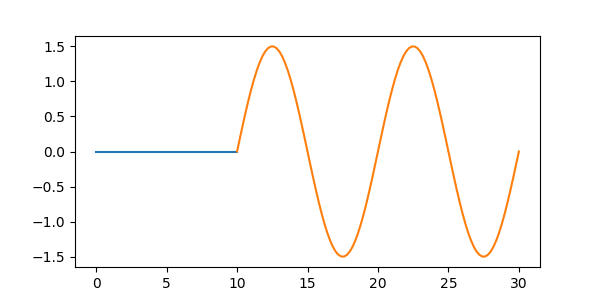

In [2]:
from silq.pulses.pulse_modules import PulseSequence
from silq.pulses.pulse_types import DCPulse, SinePulse

# Create two pulses
pulses = [DCPulse(name='dc', amplitude=0, t_start=0, duration=10),
          SinePulse(name='sine', power=1.5, t_start=10, duration=20, frequency=100, phase=0)]
# Combine pulses into a PulseSequence
pulse_sequence = PulseSequence(pulses=pulses)

# Display pulse sequence    
print(pulse_sequence)

# Plot pulses
plt.figure(figsize=(6,3))
for pulse in pulse_sequence:
    t_list = np.linspace(pulse.t_start, pulse.t_stop, 101)
    plt.plot(t_list, pulse.get_voltage(t_list))

It should be noted that it is usually not necessary to specify `Pulse.t_start`, but is usually inferred.
If a Pulse without explicit `t_start` is added to an empty PulseSequence, `t_start=0`
If a Pulse without explicit `t_start` is added to a non-empty PulseSequence, the pulse will be linked to the previous pulse in the PulseSequence (through `Pulse.previous_pulse`).
In this case, `Pulse.t_start = previous_pulse.t_stop`.

This is illustrated in the following example:

In [3]:
# Create two pulses without t_start
pulses = [DCPulse(name='dc', amplitude=0, duration=10),
          SinePulse(name='sine', power=1.5, duration=20, frequency=100, phase=0)]

# Combine pulses into a PulseSequence
pulse_sequence = PulseSequence(pulses=pulses)
pulse_sequence

PulseSequence with 2 pulses, duration: 30
	DCPulse(dc, A=0, t_start=0, t_stop=10)
	SinePulse(sine, f=0.00 MHz, power=1.5, t_start=10, t_stop=30)

Even though t_start is not explicitly specified, they still have the same values as before.
Furthermore, since the second pulse is linked to the first pulse, changing the duration of the first pulse automatically updates the second pulse:

In [4]:
pulse_sequence['dc'].duration = 20
pulse_sequence

PulseSequence with 2 pulses, duration: 40
	DCPulse(dc, A=0, t_start=0, t_stop=20)
	SinePulse(sine, f=0.00 MHz, power=1.5, t_start=20, t_stop=40)

# Pulse attributes from config
Different measurements often contain identical pulses, for instance a pi pulse, which requires a specific frequency, amplitude and duration.
If these properties were hardcoded for each measurement, each time one of the properties would change, it would have to be updated in each measurement code.
To solve this issue, properties of common pulses can be stored in the QCoDeS config.
If a Pulse property is not explicitly defined for a pulse, it will check if it has a value in the config, and use that value instead.

As an example, we add properties of a pulse with name `pi` to the pulse_config (defined above)

In [9]:
pulse_config['pi'] = {'duration': 2.5, 'frequency': 1.2e6, 'power': 0.5}

When we then create a pulse with name `pi`, it will automatically use properties that are not explicitly defined from the pulse_config

In [11]:
SinePulse('pi')

SinePulse(pi, f=1.20 MHz, power=0.5, t_start=0, t_stop=2.5)

It is also possible to manually override some of the parameters, in this case the duration

In [12]:
SinePulse('pi', duration=10)

SinePulse(pi, f=1.20 MHz, power=0.5, t_start=0, t_stop=10)

For many of the measurements (defined in [acquisition_parameters.py](..\silq\parameters\acquisition_parameters.py)), the associated PulseSequences only contain names of pulses.
It is assumed that the relevant properties of those pulses are already stored in the QCoDeS config, as they are dependent on the experimental setup. It should be noted that the QcoDeS config can be stored and loaded from hard drive, and so does not need to be created each time.

### Future work
- Conditional operations, such as deciding what pulses to apply depending on a measurement outcome.
- Efficient implementation of subroutines (a PulseSequence within a PulseSequence)
- Easy handling of cases when pulses need to be directed to different lines (e.g. two connections both can implement sine pulses, and sinepulse1 needs to be directed to connection1, and sinepulse2 to connection2).

# Attributes and methods

## Pulse
Every type of `Pulse` has its own class (e.g. SinePulse, TriggerPulse), and is a child of the `Pulse` class.
All pulses are defined in [silq\pulses\pulse_types.py](..\silq\pulses\pulse_types.py).

### Common Pulse attributes:
- **name** (str): name of pulse, can be used to extract default attribute values from config (see below)
- **t_start** (float): start time of pulse (if not defined, equal to end of previous pulse when added to PulseSequence).
- **duration** (float): pulse duration (if not defined, equal to t_stop - t_start).
- **t_stop** (float): stop time (if not defined, equal to t_start + duration).
- **acquire** (bool): acquire pulse by acquisition instrument.
- **enabled** (bool): enable pulse (if not, it is not distributed by Layout).
- **initialize** (bool) pulse is an initialization pulse, i.e. before the actual start of the PulseSequence (e.g. SteeredInitializationPulse)
- **connection** (Connection): Connection where it belongs to after targeting (None by default)
- **connection_requirements** (dict): properties a connection should satisfy (such as being triggering instrument of other instrument). This can be used to direct a pulse to a specific connection. 

Additionally, pulses can have additional attributes, such as **frequency**, depending on the pulse type

### Common Pulse methods:
- **copy**: Create a copy of the Pulse object. You can optionally fix all the variables (i.e. they do not depend on other Pulses anymore).
- **get_voltage**: Get voltage of pulse at a specific time, or a list of times.
- **satisfies_conditions**: Check if a pulse satisfies conditions. Used for filtering a pulse out of a PulseSequence.
- **target_pulse** (only for pulseImplementation): Tailors a pulseImplementation to a specific pulse. At this stage a copy of the untargeted pulse is returned, but with an intstrument-specific implementation.
- **implement** (only for PulseImplementation): Implements the pulse for a specific instrument.

## PulseSequence

A PulseSequence consists of pulses and defines a measurement.

### PulseSequence attributes
- **pulses** (Pulse list): List of pulses in the PulseSequence
- **allow_untargeted_pulses** (bool): Allow untargeted (generic) pulses into the PulseSequence
- **allow_targeted_pulses** (bool): Allow targeted pulses (PulseImplementations) into the PulseSequence
- **allow_pulse_overlap** (bool): Allow pulses to overlap in time (if pulses are bound to connections they must also share the same connection to be overlapping)
- **duration** (float): Duration of the entire PulseSequence (by default equal to `t_stop` of final pulse)

### PulseSequence methods
- **add**: Add pulse(s) to PulseSequence
- **remove**: Remove pulse(s) to PulseSequence
- **sort**: Internally sort the pulses by `t_start`
- **clear**: Clear all pulses
- **copy**: Create a copy of PulseSequence (separate object)
- **pulses_overlap**: Check if two pulses overlap in time (and connection if defined)
- **get_pulse(s)**: Get pulse(s) matching certain conditions
- **get_connection**: Get connection of pulse matching certain conditions
- **get_transition_voltages**: Get transition voltage betweeen two pulses
